# Set up

In [46]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from utils import BayesianTransformer, VisualizeBT_coin_toss, train_models_wrapper
import sys

import os
import torch
import torch.nn.functional as F

from jaxtyping import Float, Int
from torch import Tensor
from transformer_lens import ActivationCache, HookedTransformer
from transformer_lens.utils import get_act_name
from transformer_lens.hook_points import HookPoint
import einops
import plotly.express as px

torch.set_grad_enabled(False)

sys.path.append("/home/alejo/Projects")
import my_plotly_utils as mpu
from my_plotly_utils import hist, bar, scatter, imshow, figs_to_subplots
import einops

# sometimes need to reset nviidai_uvm from command line
#> sudo rmmod nvidia_uvm
#> sudo modprobe nvidia_uvm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#########################################################
########### LOAD A SAVED TRANSFORMER MODEL ##############
#########################################################

# but for now all models were trained with 100 episdoes per
n_episodes_batch = 100  #TODO: Decrease this to 16 or 32, or some multiple of 2
# how many episodes to test on
n_test_trials = 100
# number of times we toss the coin or roll the dice
n_trials = len_episode = 10 
# how often we predict during training; not used for this base model - but other models have this enabled
predict_during_training_interval = 100
predict_during_training = True                  # this saves model predictions every x timesteps
# # of layers of the transformer
n_layers_array = [1]  # [1,10,100]

####################################
n_training_epochs_array = [10000]    #  [10,100,1000, 10000]

# OPTION #1
coin_toss_params_list = [
              #  [1,1],
               #[5,1.2],
               #[0.1,0.1],
               [15,50],
             ]

##############################################
game_type = "coin_toss"
params_list = dice_roll_params_list if game_type=="dice_roll" else coin_toss_params_list

####################################
#
coin_toss_params = dice_roll_params = coin_toss_params_list[0]
n_layers = n_layers_array[0]
n_training_epochs = n_training_epochs_array[0]
params = params_list[0]
#
bt = BayesianTransformer(n_layers,
                          n_training_epochs,
                          n_episodes_batch,
                          n_trials,
                          game_type,
                          coin_toss_params,
                          dice_roll_params)        

#
bt.root_dir = os.getcwd()

#
bt.n_test_trials = n_test_trials

# if using multi distributions
bt.params_list = params_list
bt.use_multi_distributions = False
bt.predict_during_training = predict_during_training
bt.predict_during_training_interval = predict_during_training_interval

# make the model filename
bt.make_model_name()

print ("Loading model: ", bt.fname_model)
bt.load_model()
model: HookedTransformer = bt.model
# import torch
# import re
# filename = re.split('\.btrans', bt.fname_model)[0]
# torch.save(bt.model.state_dict(), filename + '.pt')

... coin toss params:  [15, 50]
... params:  [15, 50]
searching for model:  /home/alejo/Projects/CHERI_Aug_2023/alejo_exploration/model_nlayers_1_ntraining_10000_ncoin_tosses_10_coin_toss_[15, 50].btrans
Loading model:  /home/alejo/Projects/CHERI_Aug_2023/alejo_exploration/model_nlayers_1_ntraining_10000_a0_15_b0_50.btrans
... resetting cuda device ...
... cuda available:  True
Moving model to device:  cuda
Loading:  /home/alejo/Projects/CHERI_Aug_2023/alejo_exploration/model_nlayers_1_ntraining_10000_a0_15_b0_50.btrans


# Disorganized exploration

In [11]:
toks, target = bt.make_data_generator_coin_toss(1000, a0=15, b0=50)
target = torch.Tensor(np.array(target)).to('cuda')

logits, cache = model.run_with_cache(toks)
resid_stack, labels = cache.decompose_resid(return_labels=True)
logit_attr = cache.logit_attrs(resid_stack, tokens=1, incorrect_tokens=0) # The contribution of each component to the logit difference between heads and tails
logit_attr = logit_attr - logit_attr.mean(dim=[1, 2], keepdim=True)

print(toks[0])
print(logits[0, :, 1] - logits[0, :, 0])
mpu.imshow(logit_attr[:, :50], animation_frame=1, y=labels, title="Logit Atrribution across tokens (1 - 0 direction)",
           labels=dict(x='Token position', animation_frame='Datapoint'))

tensor([2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')
tensor([1.1897, 1.2260, 1.2663, 1.2942, 1.3236, 1.3529, 1.3723, 1.3990, 1.2757,
        1.1551, 1.1678], device='cuda:0')


In [30]:
attn_pattern.quantile(0.95, dim=0)
# attn_pattern.shape

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.7297, 0.2706, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.5053, 0.3508, 0.2674, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.3897, 0.2458, 0.2491, 0.2401, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.2784, 0.2220, 0.2097, 0.2198, 0.2126, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.1969, 0.2177, 0.2097, 0.1695, 0.1880, 0.1630, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.1653, 0.1926, 0.1825, 0.1584, 0.1743, 0.1733, 0.1927, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.1252, 0.1576, 0.1571, 0.1306, 0.1701, 0.1499, 0.1463, 0.1420, 0.0000,
         0.0000, 0.0000],
        [0.1052, 0.1498, 0.1449, 0.1168, 0.1568, 0.1248, 0.1286, 0.1376, 0.1409,
         0.0000, 0.0000],
        [0.0789, 0.1401, 0.1376, 0.11

In [34]:
import torch
import plotly.express as px
from transformer_lens.utils import get_act_name
from transformer_lens import ActivationCache

logits, cache = model.run_with_cache(toks)
cache: ActivationCache
attn_pattern = cache['pattern', 0].squeeze()

# max_min_attn = attn_pattern.max(0).values - attn_pattern.min(0).values
max_min_attn = attn_pattern.quantile(0.95, dim=0) - attn_pattern.quantile(0.05, dim=0)
mpu.imshow(attn_pattern.mean(0), title='Mean attention pattern')
mpu.imshow(max_min_attn / attn_pattern.mean(0), title='Variation range of attention pattern')
# px.line(logits[..., :2].squeeze())

In [51]:
from copy import deepcopy

def mean_ablate_mlp(neurons: Float[Tensor, 'batch pos d_mlp'], hook: HookPoint) -> Float[Tensor, 'batch pos d_mlp']:
    batch, pos, _ = neurons.shape
    mean_neurons = neurons.mean(dim=[0, 1], keepdim=True)
    return einops.repeat(mean_neurons, '1 1 d_mlp -> batch pos d_mlp', batch=batch, pos=pos)
    # mean_neurons = neurons.mean(dim=0, keepdim=True)
    # return einops.repeat(mean_neurons, '1 pos d_mlp -> batch pos d_mlp', batch=batch)

def loss(logits: Float[Tensor, 'batch pos vocab'], labels: Float[Tensor, 'batch']) -> float:
    # L2 loss for now
    log_probs = logits.log_softmax(dim=-1)
    prob_labels = torch.stack([labels, 1-labels, torch.zeros_like(labels)], dim=-1)
    return F.kl_div(log_probs, prob_labels[:, None, :], reduction='batchmean').item()
    # probs = logits.softmax(dim=-1)
    # return ((probs[..., 0] - labels) ** 2).mean().item()

def normalized_loss(logits: Float[Tensor, 'batch pos vocab'], labels: Float[Tensor, 'batch']) -> float:
    return (loss(logits, labels) - loss_orig)/(loss_orig)

# Testing the model can predict the mean of the coin tosses
toks, target = bt.make_data_generator_coin_toss(1000, a0=15, b0=50)
target = torch.Tensor(np.array(target)).to('cuda')
logits = model(toks)
logits_no_mlp = model.run_with_hooks(toks, fwd_hooks=[(get_act_name('post', 0, 'mlp'), mean_ablate_mlp)])

model_mean_pos_embed = deepcopy(model)
model_mean_pos_embed.W_pos.data = einops.repeat(model_mean_pos_embed.W_pos.mean(0), 'd_model -> n_ctx d_model', n_ctx=model.cfg.n_ctx)
# model_mean_pos_embed.W_E.data = einops.repeat(model_mean_pos_embed.W_E.mean(0), 'd_model -> d_vocab d_model', d_vocab=model.cfg.d_vocab)
logits_mean_pos_embed = model_mean_pos_embed(toks)

W_OV = model.W_V @ model.W_O.transpose(-1, -2)
W_OV = W_OV.squeeze().detach()
ov_path = model.W_E @ W_OV @ model.W_U
logits_ov_path = ov_path[toks[:, 1:]]
# logits_ov_path = ov_path[toks[:, 1:]].cumsum(dim=1) / torch.arange(1, 11)[:, None].to('cuda')
logits_ov_path = torch.stack([logits_ov_path[:, :i+1].mean(1) for i in range(10)], dim=1)
logits_ov_path[..., 0] -= 0.5

loss_orig = loss(logits, target)
loss_naive = loss(torch.ones_like(logits), target)
print(f'Loss model {loss_orig: .3f}')
print(f'Naive loss {loss_naive: .3f}')

print(f'Loss increase mlp mean-ablated {100*normalized_loss(logits_no_mlp, target): .1f}%')
print(f'Loss increase pos embed mean-ablated {100*normalized_loss(logits_mean_pos_embed, target): .1f}%')
print(f'Loss increase direct OV path {100*normalized_loss(logits_ov_path, target): .1f}%')
print(f'Loss direct OV path {loss(logits_ov_path, target): .3f}')

Loss model  92.164
Naive loss  6222.747
Loss increase mlp mean-ablated -4.6%
Loss increase pos embed mean-ablated  13.0%
Loss increase direct OV path  5408.8%
Loss direct OV path  5077.148


In [22]:
logit_diff = logits[..., 1] - logits[..., 0]
logit_diff_ov = logits_ov_path[..., 1] - logits_ov_path[..., 0]

joint_logit_diff = torch.stack([logit_diff[:, 1:], logit_diff_ov], dim=0)
# corr_by_pos = [torch.corrcoef(joint_logit_diff[..., i])[0, 1].item() for i in range(10)]
# px.bar(corr_by_pos, title='Correlation of output logit difference and OV only logit difference by position')

figs = []
for pos in [1, 3, 6, 9]:
    x, y = joint_logit_diff[:, :, pos]
    fig = mpu.scatter(x, y, trendline='ols', return_fig=True)
    figs.append(fig)

figs_to_subplots(figs, shared_xaxes=True, shared_yaxes=True, subplot_titles=[f'Position {pos}' for pos in [1, 3, 6, 9]],
                 title="Model's logit difference vs. OV path logit difference at different positions",
                 xaxis="Model's logit difference", yaxis="OV path logit difference")

In [14]:
logits_ov_path = ov_path[toks[:, :-1]]
# logits_ov_path = ov_path[toks[:, 1:]].cumsum(dim=1) / torch.arange(1, 11)[:, None].to('cuda')
logits_ov_path = torch.stack([logits_ov_path[:, :i+1].mean(1) for i in range(10)], dim=1)
logits_all_bias_ov_path = []
bias_values = np.linspace(-2, 2, 100)
for bias in bias_values:
    logits_ov_path_bias = logits_ov_path.clone()
    logits_ov_path_bias[..., 0] += bias
    logits_all_bias_ov_path.append(logits_ov_path_bias)

norm_loss_by_bias = [normalized_loss(logits, target) for logits in logits_all_bias_ov_path]
mpu.line(norm_loss_by_bias, x=bias_values, title='Normalized loss from average of OV projection of the embeddings for different biases')

In [9]:
W_OV = model.W_V @ model.W_O.transpose(-1, -2)
W_OV = W_OV.squeeze().detach()
ov_path = model.W_E @ W_OV @ model.W_U

logits_ov_path = ov_path[toks[:, :-1]]
# logits_ov_path = ov_path[toks[:, 1:]].cumsum(dim=1) / torch.arange(1, 11)[:, None].to('cuda')
logits_ov_path = torch.stack([logits_ov_path[:, :i+1].mean(1) for i in range(10)], dim=1)

logit_diff_ov_path = logits_ov_path[..., 1] - logits_ov_path[..., 0]
print(logit_diff_ov_path.shape)
mpu.imshow(logit_diff_ov_path[None, :50], animation_frame=1, title='Logit attribution for the head by computing OV path manually',
           labels=dict(x='Token position', animation_frame='Datapoint'))

torch.Size([1000, 10])


## Even more disorganized

In [18]:
W_E = bt.model.W_E.detach()
W_pos = bt.model.W_pos.detach()
W_U = bt.model.W_U.detach()

W_OV = bt.model.W_V @ bt.model.W_O.transpose(-1, -2)
W_OV = W_OV.squeeze().detach()

W_E_pos_heads = einops.repeat(W_E[1], 'd -> pos d', pos=W_pos.shape[0])
W_E_pos_heads[0] = W_E[2]
moving_mean = 1/torch.arange(1, W_pos.shape[0] + 1)
pos_logits = ((W_pos + W_E_pos_heads) @ W_OV @ W_U).cumsum(0) * moving_mean[:, None]
pos_logits_diff = pos_logits[:, 1] - pos_logits[:, 0]
embed_logits_basic = W_E @ W_OV @ W_U
embed_logits_basic_diff = embed_logits_basic[:, 1] - embed_logits_basic[:, 0]

# mpu.line([l for l in pos_logits.unbind(1)])
mpu.line(embed_logits_basic_diff)
# mpu.line([l for l in embed_logits_basic.unbind(1)])
# mpu.line([l for l in embed_logits.unbind(1)])
# mpu.line(embed_logits_diff)
mpu.line(pos_logits_diff)
# mpu.line([pos_logits_diff, torch.arange(1, 101).log()])

In [50]:
W_E = bt.model.W_E.detach()
W_pos = bt.model.W_pos.detach()
W_U = bt.model.W_U.detach()

W_OV = bt.model.W_V @ bt.model.W_O.transpose(-1, -2)
W_OV = W_OV.squeeze().detach()

W_E_pos_heads = einops.repeat(W_E[1], 'd -> pos d', pos=W_pos.shape[0])
moving_mean = 1/torch.arange(1, W_pos.shape[0] + 1)
# pos_logits = W_pos.cumsum(0)*moving_mean[:, None] @ W_OV @ W_U
pos_logits = ((W_pos + W_E_pos_heads)*moving_mean[:, None]).cumsum(0) @ W_OV @ W_U
embed_logits = ((W_E_pos_heads)*moving_mean[:, None]).cumsum(0) @ W_OV @ W_U
# embed_logits = (((W_E_pos_heads)).cumsum(0)*moving_mean[:, None])  @ W_OV @ W_U
pos_logits_diff = pos_logits[:, 1] - pos_logits[:, 0]
embed_logits_diff = embed_logits[:, 1] - embed_logits[:, 0]

mpu.line([l for l in pos_logits.unbind(1)])
# mpu.line([l for l in embed_logits.unbind(1)])
# mpu.line(embed_logits_diff)
mpu.line([pos_logits_diff, torch.arange(1, 101).log()])

In [79]:
W_E = bt.model.W_E
W_pos = bt.model.W_pos

sim_W_E = W_E @ W_E.T
U, S, V = W_pos.svd()
sim_W_pos = U @ U.T
sim_W_pos.masked_fill_(torch.eye(sim_W_pos.shape[0]).bool(), 0)

# mpu.line(S)
mpu.line([u for u in U[:20, :10].unbind(1)])
mpu.line(W_pos.norm(dim=1)) # Perhaps try the projection of W_pos through the OV circuit until unembed

mpu.imshow(sim_W_pos[:20, :20])
# mpu.imshow(W_pos)
# mpu.imshow(sim_W_E)

In [ ]:
toks = torch.randint(0, 2, size=(1000, 10))

logits, cache = bt.model.run_with_cache(toks)



test data:  tensor([2, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
transformer prediction:  [0.4703349  0.6529752  0.47094136 0.37551925 0.3064341  0.42648506
 0.35688636 0.3245099  0.38931903 0.45834202 0.48962334]
a:  2  b:  1  y:  0.6666666666666666
a:  2  b:  2  y:  0.5
a:  2  b:  3  y:  0.4
a:  2  b:  4  y:  0.3333333333333333
a:  3  b:  4  y:  0.42857142857142855
a:  3  b:  5  y:  0.375
a:  3  b:  6  y:  0.3333333333333333
a:  4  b:  6  y:  0.4
a:  5  b:  6  y:  0.45454545454545453
a:  6  b:  6  y:  0.5
bayesian optimal:  [0.5        0.66666667 0.5        0.4        0.33333333 0.42857143
 0.375      0.33333333 0.4        0.45454545 0.5       ]


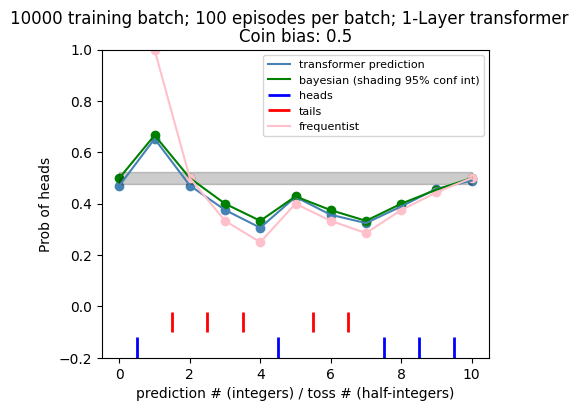

In [6]:
#####################################################
############## VISUALIZE RESULTS ####################
#####################################################

# run this notebook several times to visualize the transformer prediction against bayesian optimal and frequentist predictions

#
vis = VisualizeBT_coin_toss(bt)
vis.save_svg=False
vis.show_kl_entropy = False
vis.use_multi_distributions = False
vis.show_frequentist = True
vis.show_examples(1)

#


In [10]:
# Generate a sample from the Dirichlet distribution
alpha = [1, 1, 1]

sample = np.random.dirichlet(alpha)

print("Sample from Dirichlet distribution:", sample)

Sample from Dirichlet distribution: [0.4771895  0.33177353 0.19103697]
